# Dataset Build

This notebook will go through my target selection process step by step to make sure the selections and cuts are fully transparent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',10)
# sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25)
matplotlib.rc('axes',labelsize=25) 
from astropy.table import Table
import os
__ddir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'
try:
    os.mkdir(__ddir__+'targetlists')
except OSError:
    pass

I'll be using the function below to remove duplicates thoughout this code.

In [2]:
def kill_duplicates(df,ID, sep):
    df = df.copy(deep=True)
    sel = df.duplicated(ID, keep=False)
    s = df[sel]
    for idx in range(s[ID].nunique()):
        subset = s[s[ID] == s[ID].values[idx]]
        lock = True  #Iterate and remove the target of largest separation
        while lock:
            if len(subset) > 1.:
                drop = subset[sep].idxmax()
                subset.drop(drop, inplace=True)
                s.drop(drop,inplace=True)
                df.drop(drop, inplace=True)
            elif len(subset == 1.):
                lock = False
            else:
                print('The code shouldnt be here?')
    return df

### 1) Read in the [Kepler x DR2](https://gaia-kepler.fun/) catalogue (thanks Megan Bedell!)

In [3]:
data = Table.read(__ddir__+'kepler_dr2_1arcsec.fits', format='fits')
kdf = data.to_pandas()
kdf.rename(columns={'kepid':'KICID',
                    'phot_g_mean_mag':'GAIAmag',
                    'a_g_val': 'Ag',
                    'logg':'kic_logg'},inplace=True)

#We need to construct some typical uncertainties on GAIAmag:
kdf['e_GAIAmag'] = np.ones(len(kdf)) * 10.0e-3
print('Targets in Kep x DR2: '+str(len(kdf)))

Targets in Kep x DR2: 195830


### 2) Read in the [Yu et al. 2018](http://adsabs.harvard.edu/abs/2018arXiv180204455Y) catalogue

In [4]:
sfile = '../../Catalogues/RC_catalogues/Yu+18_table1.txt'
yu18_1 = pd.read_csv(sfile, sep='|')

sfile = '../../Catalogues/RC_catalogues/Yu+18_table2.txt'
yu18_2 = pd.read_csv(sfile, sep='|')
yu18 = pd.merge(yu18_1, yu18_2, on='KICID',how='left')
yu18.rename(columns={'EvoPhase':'stage',
                    'err_x':'numax_err',
                    'err.1_x':'dnu_err',
                    'err_y':'Teff_err',
                     'Fe/H':'[Fe/H]',
                    'err.2':'[Fe/H]_err',
                    'logg':'logg',
                    'err.1_y':'logg_err',
                    'err.3_y':'M_noCorrection_err',
                    'err.4_y':'R_noCorrection_err',
                    'err.5':'M_RGB_err',
                    'err.6':'R_RGB_err',
                    'err.7':'M_Clump_err',
                    'err.8':'R_Clump_err'},inplace=True) #For consistency
print('Targets: '+str(len(yu18)))

Targets: 16094


### 3) Merge the KeplerxDR2 and Yu18 catalogues on KIC

In [5]:
xyu18 = pd.merge(yu18, kdf, on='KICID',how='left')
print('Targets: '+str(len(xyu18)))

Targets: 16135


#### 3.1) Only keep duplicates with the smallest angular separation

In [6]:
xyu18 = kill_duplicates(xyu18, 'KICID', 'kepler_gaia_ang_dist')
print('Targets: '+str(len(xyu18)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Targets: 16094


#### 3.2) Removing any infinite parallax values

In [7]:
xyu18 = xyu18[np.isfinite(xyu18.parallax)]
print('Targets: '+str(len(xyu18)))

Targets: 16037


### 4) Select Core Helium Burning stars only

In [8]:
rcxyu18 = xyu18[xyu18.stage==2]
print('Targets: '+str(len(rcxyu18)))

Targets: 7673


#### Save out a list of targets

In [9]:
out = rcxyu18['KICID'].astype(str)
out.to_csv(__ddir__+'/targetlists/cheb_targetlist_int.txt', index=False) #Save one without KIC in the label
out = out.apply(lambda x: 'KIC ' + x)
out.to_csv(__ddir__+'/targetlists/cheb_targetlist.txt',index=False) #And one with KIC

### 5) Add photometry from [2MASS](http://vizier.u-strasbg.fr/cgi-bin/VizieR?-source=B/2mass) (and other useful information)
I'll also remove any data that have negative or otherwise unphysical magnitudes or uncertainties.

In addition to the 2MASS photometry, we also use the measure of magnitude in the *Gaia* *G* Band provided with the *Gaia* sample.

The subsection of the 2MASS catalogue here was requested through *Vizier* on KICID for all CHeB labeled stars in this sample.

#### 5.1) Read in the data

In [10]:
twomass = pd.read_csv('../data/KepxDR2/2mass.tsv',sep='|',skiprows=48)
twomass['KICID'] = ''
twomass['KICID'] = twomass['_1'].apply(lambda x: x[4:]).str.strip()
twomass = twomass[:-1] #Delete broken final column
print('Targets in 2MASS: '+str(len(twomass)))

Targets in 2MASS: 7811


#### 5.2) Remove duplicates on angular distance to target

In [11]:
twomass = kill_duplicates(twomass, 'KICID', '_r')
print('Targets in 2MASS: '+str(len(twomass)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Targets in 2MASS: 7672


#### 5.3) Merge with our data

In [12]:
rcxyu18['KICID'] = rcxyu18.KICID.astype(str)
rcxyu18 = pd.merge(rcxyu18, twomass, on='KICID',how='left')
print('Targets: '+str(len(rcxyu18)))

Targets: 7673


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### 5.4) Fix readin strings that should be floats, and remove NaN values

In [13]:
#Kill NaN values for J band mag err (and by association J band mag)
rcxyu18['e_Jmag'] = rcxyu18['e_Jmag'].str.strip()
rcxyu18.drop(rcxyu18[rcxyu18.e_Jmag == ''].index.values, inplace=True)
rcxyu18['e_Jmag'] = rcxyu18.e_Jmag.astype(float)

#Kill NaN values for K band mag err (and by association K band mag)
rcxyu18.drop(rcxyu18[~np.isfinite(rcxyu18.e_Kmag)].index.values, inplace=True)
rcxyu18['Kmag'] = rcxyu18['Kmag'].str.strip()
rcxyu18['Kmag'] = rcxyu18.Kmag.astype(float)

#Kill NaN values forHK band mag err (and by association K band mag)
rcxyu18['e_Hmag'] = rcxyu18['e_Hmag'].str.strip()
rcxyu18.drop(rcxyu18[rcxyu18.e_Hmag == ''].index.values, inplace=True)
print('Targets: '+str(len(rcxyu18)))

Targets: 7630


### 5.5: Add CCD information (to later partition stars by position on sky)

I request this information using the *Skygroup ID* values from MAST.

In [14]:
nodes = pd.read_csv(__ddir__+'nodelist.txt',skiprows=[1])
nodes.rename(columns={'Kepler_ID':'KICID'},inplace=True)
nodes.KICID = nodes['KICID'].astype('str')
print('Number of targets with node info: '+str(len(nodes)))

Number of targets with node info: 7630


In [15]:
rcxyu18 = pd.merge(rcxyu18, nodes, how='left', on='KICID')
rcxyu18['ccd'] = np.array([int((id- 1)/4) for id in rcxyu18['Skygroup_ID'].values])
rcxyu18.head()
print('Targets: '+str(len(rcxyu18)))

Targets: 7630


### 5.6: Check the source of the Teff values in Yu+18

The values in Yu+18 for temperature have been sourced from the [Vizier Catalogue for Mathur+17](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/ApJS/229/30/catalog). We want to make sure that the temperatures we're using are from surveys using the same or similar temperature scales.

In [16]:
mathur17 = pd.read_csv('../data/KepxDR2/mathur_teffs.tsv',sep='|',skiprows=49)
mathur17 = mathur17[2:].reset_index(drop=True)
mathur17.rename(columns={'KIC':'KICID', 'Teff':'Teff_M'},inplace=True)
mathur17['KICID'] = mathur17['KICID'].str.strip()
mathur17 = mathur17[:-1] #Delete broken final column
mathur17.drop(columns=['_1','_r'], inplace=True)
print('Targets in in Mathur+17: '+str(len(mathur17)))

Targets in in Mathur+17: 7673


In [17]:
mathur17 = kill_duplicates(mathur17, 'KICID', '_r')
print('Targets in Mathur+17: '+str(len(mathur17)))

Targets in Mathur+17: 7673


In [18]:
rcxyu18 = pd.merge(rcxyu18, mathur17, on='KICID',how='left')
print('Targets: '+str(len(rcxyu18)))

Targets: 7630


### 6) Get reddening & extinction from [Bayestar 17](http://argonaut.skymaps.info/) ([Green et al. 2018](http://adsabs.harvard.edu/abs/2018AAS...23135002G))

We use the [Bailer-Jones estimated distance](https://arxiv.org/abs/1804.10121) to get a measure of the reddening. Any changes in reddening due to using this value over, say, using 1/$\varpi$, falls within the priors on extinction in our model.

For extinction coefficients, please see references on [omnitool.literature_values](https://github.com/ojhall94/omnitool/blob/master/omnitool/literature_values.py).

**It is important to note that** Bayestar 17 does **not** report E(B-V) values. Instead, the relation holds that $E(B-V) = 0.88 \times $ the Bayestar 17 value. Extinction coefficients reported with the Bayestar release are for **the Bayestar values specifically**, and not a value of E(B-V).

For the Ag, we use the extinction reported in the *Gaia* DR2 catalogue.

In [19]:
from omnitool import spyglass
from omnitool.literature_values import Av_coeffs
sg = spyglass()
sg.pass_position(rcxyu18.ra, rcxyu18.dec, frame='icrs')
sg.pass_distance(rcxyu18.r_est)
rcxyu18['b17'], rcxyu18['Ebv'] = sg.get_b17_ebv()
rcxyu18['Aks'] = rcxyu18.b17 * Av_coeffs['K'].values[0]
rcxyu18['Aj'] = rcxyu18.b17 * Av_coeffs['J'].values[0]
rcxyu18['Ah'] = rcxyu18.b17 * Av_coeffs['H'].values[0]
rcxyu18['H17_Ag'] = rcxyu18.Ebv * Av_coeffs['G'].values[0]

### 7) Calculate (a basic) asteroseismic bolometric magnitude
We'll do this using my omnitool package to run the asteroseismic scaling relations (no corrections to them for now).

Bolometric Corrections are taken using the method by [Casagrande & Vandenburg 2018](http://adsabs.harvard.edu/abs/2018ascl.soft05022C)

#### 7.1) Get the asteroseismic bolometric magnitude

In [20]:
from omnitool.literature_values import Rsol, Msol, Lsol, Zsol
from omnitool import scalings

sc = scalings(rcxyu18.numax, rcxyu18.dnu, rcxyu18.Teff,\
                      _numax_err = rcxyu18.numax_err, _dnu_err = rcxyu18.dnu_err,\
                      _Teff_err = rcxyu18.Teff_err)
rcxyu18['L'] = sc.get_luminosity()/Lsol
rcxyu18['L_err'] = sc.get_luminosity_err()/Lsol
rcxyu18['Mbol'] = sc.get_bolmag()
rcxyu18['Mbol_err'] = sc.get_bolmag_err()
rcxyu18['Z'] = Zsol * 10 ** rcxyu18['[Fe/H]'].values

Calculating luminosity using basic asteroseismic radius
Calculating luminosity using basic asteroseismic radius
Calculating luminosity using basic asteroseismic radius


#### 7.2) Save out the data as it stands for a run through the Elsworth+17 method

In [21]:
rcxyu18.to_csv('../data/KepxDR2/rcxyu18_pre_elsworth.csv',index=False)
print('Targets: '+str(len(rcxyu18)))

Targets: 7630


##### 7.2.1) Save out a list of the IDs for the stars previously excluded on parallax uncertainty

In [22]:
out = rcxyu18[rcxyu18.parallax_error/rcxyu18.parallax > .35]['KICID'].astype(str)
out = out.apply(lambda x: 'KIC ' + x)
out.to_csv(__ddir__+'targetlists/rc_targetlist_highunc.txt',index=False)
print('Targets in highunc list: ' +str(len(out)))

Targets in highunc list: 133


# Lets just check the contents of the elsworth catalogues

In [23]:
elsrc = pd.read_csv('../data/KepxDR2/ElsRc/RC-v1.txt', header=None)
elsrc.rename(columns={0:'KICID'},inplace=True)
elsrc.KICID = elsrc['KICID'].astype('str')
print(len(elsrc)+27)

5605


The file above contains the initial classification of the 'low' uncertainty stars. 27 of these stars were removed based on inspection of their mass.

I then sent an additional sample of 133 high uncertainty targets, of which she had data for 113 stars.
In addition to this, Yvonne reevaluated 27 targets she previously did not have lightcurves for.

In [24]:
uncv4 = pd.read_csv('../data/KepxDR2/ElsRc/unc-v4.txt', header=None, sep='\t')
uncv4.rename(columns={0:'KICID', 1:'label'},inplace=True)
uncv4.KICID = uncv4['KICID'].astype('str')
print(len(uncv4[uncv4.label == 'RC']))

48


And then finally we have the list that she sent the first time I sent the 133 high uncertainty targets, which is:

In [25]:
rc3 = pd.read_csv('../data/KepxDR2/ElsRc/RC-v3.txt',header=None)
rc3.rename(columns={0:'KICID'},inplace=True)
rc3['KICID'] = rc3.KICID.astype('str')
print(len(rc3))

63


### 8) Use Elsworth + 17 method classifications as our gold standard

In [26]:
elsclass = pd.read_csv('../data/KepxDR2/ElsRc/RC-v1.txt',header=None)
elsclass.rename(columns={0:'KICID'},inplace=True)
elsclass.KICID = elsclass['KICID'].astype('str')

In [27]:
elsclass2 = pd.read_csv('../data/KepxDR2/ElsRc/RC-v3.txt',header=None)
elsclass2.rename(columns={0:'KICID'},inplace=True)
elsclass2['KICID'] = elsclass2.KICID.astype('str')
elsclass = elsclass.append(elsclass2)

In [28]:
rcxyu18 = pd.merge(elsclass, rcxyu18, on='KICID',how='left')
print('Targets: '+str(len(rcxyu18)))

Targets: 5641


Of these stars, there are a number that have been identified as belonging to the RC due to the seismic method, but have very large masses. We exclude these stars by truncating at 2.2 solar masses.

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Mass (Mdot)')

/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


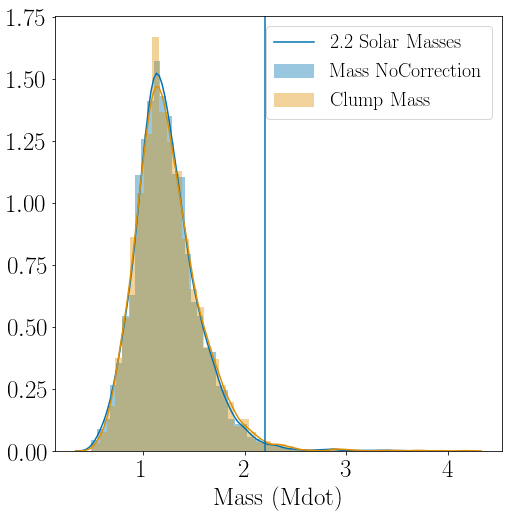

In [29]:
# import matplotlib
# matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(rcxyu18.M_noCorrection, ax=ax, label='Mass NoCorrection')
sns.distplot(rcxyu18.M_Clump, ax=ax, label='Clump Mass')
ax.axvline(2.2, label='2.2 Solar Masses')
ax.legend(fontsize=20)
ax.set_xlabel('Mass (Mdot)')

In [30]:
excl = len(rcxyu18[rcxyu18.M_Clump >= 2.2])
rcxyu18 = rcxyu18[rcxyu18.M_Clump < 2.2]
print('Targets: '+str(len(rcxyu18)))

Targets: 5576


Note that in the RC-v1.txt catalogue 27 stars have already been excluded on mass. This makes the total number of stars excluded on mass:

In [31]:
print(excl + 27)

92


### Final count of targets in ours sample:

In [32]:
rcxyu18.to_csv('../data/KepxDR2/rcxyu18.csv',index=False)
out = rcxyu18['KICID']
out = out.apply(lambda x: 'KIC ' + x)
out.to_csv('../data/KepxDR2/final_rcxyu18_targetlist.txt',index=False)
print(str(len(rcxyu18)))

5576


In [33]:
sys.exit()

NameError: name 'sys' is not defined

In [ ]:
BC = pd.read_csv('/home/oliver/PhD/Gaia_Project/data/KepxDR2/BCs/casagrande_bcs_0.0_singular.csv')
BC['KICID'] = BC.KICID.astype('str')
df = pd.merge(rcxyu18, BC, on='KICID', how='left')

In [ ]:
sel = df.M_Clump < 2.2
Mk = df.Mbol - df.BC_K
plt.scatter(Mk[sel], df.Kmag[sel], c= df.M_Clump[sel])
plt.colorbar()
sns.distplot(Mk)
sns.distplot(Mk[sel])
plt.show()
print(len(Mk[~sel]))

In [ ]:
rcxyu18.KICID.values

# Lets plot these on a HR diagram!

In [34]:
#Lets readin some tracks for the red clump from MESA
sfile = '/home/oliver/PhD/Catalogues/Tracks/MESA_RC/m0.80.ovh0.01d.ovhe0.50s.z0.01756.y0.26627.track'
df1 = pd.read_table(sfile, sep=r'\s+', header=0, skiprows=5, error_bad_lines=False)
# RC
df1_rc = df1[(df1['center_h1'] < 1e-8) & (df1['luminosity'] > 10) & (df1['mass_conv_core'] > 0.)]
# RGB (bearing in mind that the RGBb is probably not at the observed location)
df1 = df1[(df1['center_h1'] < 1e-8) & (df1['luminosity'] > 10) & (df1['he_core_mass'] < 0.31)]

In [35]:
masses = np.arange(0.80, 1.80, 0.20)
print(masses)

[0.8 1.  1.2 1.4 1.6]


In [36]:
zvals = ['0.00699', '0.01108', '0.01756', '0.02783']
yvals = ['0.25557', '0.25971', '0.26627', '0.27666']
mi = 1


0.013630899367999827


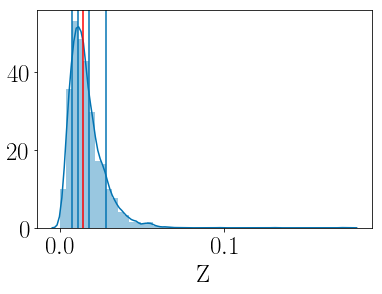

In [37]:
sns.distplot(rcxyu18.Z)
print(np.median(rcxyu18.Z))
plt.axvline(np.median(rcxyu18.Z),c='r')
for z in zvals:
    plt.axvline(np.float(z))

In [38]:
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde
import seaborn as sns
from omnitool.literature_values import Rsol, Msol, Lsol, Zsol
from omnitool import scalings

sc = scalings(xyu18.numax, xyu18.dnu, xyu18. Teff)
xyu18['L'] = sc.get_luminosity()/Lsol
xyu18['KICID'] = xyu18.KICID.astype('str')


Calculating luminosity using basic asteroseismic radius


In [39]:
apo = pd.read_csv('../data/KepxDR2/rcxyuxapokasc2.csv')
apo['KICID'] = apo.KICID.astype('str')
sc = scalings(apo.numax, apo.dnu, apo.Yu_Teff)
apo['L'] = sc.get_luminosity()/Lsol

xapo = np.log10(apo.Yu_Teff.values)
yapo = np.log10(apo.L.values)

aposel = rcxyu18.KICID.isin(apo.KICID)

x = np.log10(rcxyu18[~aposel].Teff.values)
y = np.log10(rcxyu18[~aposel].L.values)

yusel = xyu18.KICID.isin(rcxyu18.KICID)

xyu = np.log10(xyu18[~yusel].Teff.values)
yyu = np.log10(xyu18[~yusel].L.values)

Calculating luminosity using basic asteroseismic radius


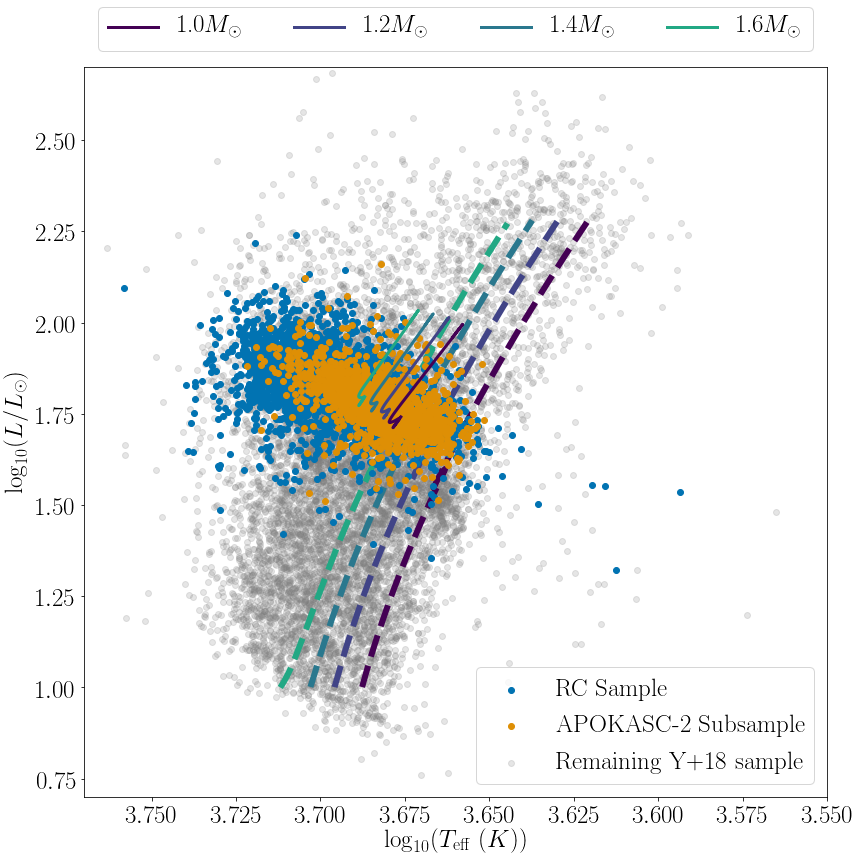

In [40]:
fig, ax = plt.subplots(figsize=(12,12))
# c = ax.hist2d(np.log10(xyu18.Teff.values), np.log10(xyu18.L.values),cmap='Greys',
#                 norm=LogNorm(), zorder=0)

s1 = ax.scatter(x, y,zorder=2, label= 'RC Sample')
s2 = ax.scatter(xapo, yapo, zorder=3, label= 'APOKASC-2 Subsample')
s3 = ax.scatter(xyu, yyu,c='grey',alpha=.2,zorder=0, label= 'Remaining Y+18 sample')

legend1 = plt.legend(handles=[s1, s2, s3], loc='lower right',fontsize=25)
plt.gca().add_artist(legend1)
handles = []

masses = np.arange(1.0, 1.8, 0.2)
colors = plt.cm.viridis(np.linspace(0,1,6))
for idx, mass in enumerate(masses):
    c = colors[idx]

    mass = str(np.round(mass, 1))
    sfile = '/home/oliver/PhD/Catalogues/Tracks/MESA_RC/m'+mass+'0.ovh0.01d.ovhe0.50s.z'+zvals[mi]+'.y'+yvals[mi]+'.track'
    df = pd.read_table(sfile, sep='\s+', header=0, skiprows=5, error_bad_lines=False)
    df_rc = df[(df['center_h1'] < 1e-8) & (df['luminosity'] > 10) 
               & (df['mass_conv_core'] > 0.)][['effective_T','log_L']]
    df_rgb = df[(df['center_h1'] < 1e-8) & (df['luminosity'] > 10) 
                & (df['he_core_mass'] < 0.31) & (df['effective_T']<5250)][['effective_T','log_L']]
    
    ax.plot(np.log10(df_rgb.effective_T.values), df_rgb.log_L.values, c=c,
            zorder=1, linewidth = 6, linestyle='--')
    handle = ax.plot(np.log10(df_rc.effective_T.values), df_rc.log_L.values, c=c,
                    zorder=4,linewidth = 3, label=str(mass) + r'$M_\odot$')
    
    handles.append(handle)
legend2 = plt.legend(handles=[handles[i][0] for i in range(len(masses))], loc='upper center',fontsize=25,
                    ncol=5, bbox_to_anchor=(.5, 1.1))
    
ax.invert_xaxis()
ax.set_ylim(0.7, 2.7)
ax.set_xlim(3.77, 3.55)
ax.set_xlabel(r'$\log_{10}(T_{\rm eff}\ (K))$',fontsize=25)
ax.set_ylabel(r'$\log_{10}(L / L_\odot)$',fontsize=25)
fig.tight_layout()
plt.savefig('/home/oliver/Dropbox/Papers/Hall+18/Figures/data.png')
plt.savefig('/home/oliver/Dropbox/Papers/Hall+18/Figures/data.pdf')
# ax.set_title('Z = '+zvals[mi]+' | Y = '+yvals[mi], fontsize=25)
plt.show()

In [ ]:
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde
import seaborn as sns
from omnitool.literature_values import Rsol, Msol, Lsol, Zsol
from omnitool import scalings

sc = scalings(xyu18.numax, xyu18.dnu, xyu18. Teff)
xyu18['L'] = sc.get_luminosity()/Lsol

x = np.log10(rcxyu18.Teff.values)
y = np.log10(rcxyu18.L.values)

#Calculate the KDE of the RC points
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]


fig, ax = plt.subplots(figsize=(8,8))
# ax.hexbin(np.log10(xyu18.Teff), np.log10(xyu18.L),gridsize=50, mincnt=1.,cmap='Greys_r')
c = ax.hist2d(np.log10(xyu18.Teff.values), np.log10(xyu18.L.values),cmap='Greys',bins=100,norm=LogNorm(), zorder=0)
ax.scatter(x, y, s=10, c=z, cmap='viridis',zorder=2)

colors = plt.cm.rainbow(np.linspace(0,1,5))
for idx, mass in enumerate(np.arange(0.8, 1.8, 0.2)):
    mass = str(np.round(mass, 1))
    c = colors[idx]
    sfile = '/home/oliver/PhD/Catalogues/Tracks/MESA_RC/m'+mass+'0.ovh0.01d.ovhe0.50s.z'+zvals[mi]+'.y'+yvals[mi]+'.track'
    df = pd.read_table(sfile, sep='\s+', header=0, skiprows=5, error_bad_lines=False)
    df_rc = df[(df['center_h1'] < 1e-8) & (df['luminosity'] > 10) & (df['mass_conv_core'] > 0.)][['effective_T','log_L']]
    df_rgb = df[(df['center_h1'] < 1e-8) & (df['luminosity'] > 10) & (df['he_core_mass'] < 0.31)][['effective_T','log_L']]
    ax.plot(np.log10(df_rgb.effective_T.values), df_rgb.log_L.values, c=c, zorder=1, linestyle='--')
    ax.plot(np.log10(df_rc.effective_T.values), df_rc.log_L.values, c=c,zorder=3,label=str(mass) + r'$M_\odot$')

ax.invert_xaxis()
ax.legend(fancybox='True', loc='lower right', fontsize=20)
ax.set_ylim(0.7, 2.7)
ax.set_xlim(3.77, 3.6)
ax.set_xlabel(r'$log_{10}(T_{\rm eff})$(K)',fontsize=20)
ax.set_ylabel(r'$log_{10}$(L)($L_\odot$)',fontsize=20)
ax.set_title('Z = '+zvals[mi]+' | Y = '+yvals[mi], fontsize=20)
plt.savefig('/home/oliver/Dropbox/Papers/Hall+18/Figures/data.png')
plt.savefig('/home/oliver/Dropbox/Papers/Hall+18/Figures/data.pdf')
plt.show()

# Lets have a look at the distribution in the Kepler field

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(rcxyu18.ra, rcxyu18.dec, c=rcxyu18.ccd, cmap='tab20b')
ax.set_xlabel('Ra')
ax.set_ylabel('Dec')
plt.show()

# Finally, lets have a look at where the $T_{\rm eff}$ values come from...

I've run *final_rcxyu18_targetlist.txt* up to the [Vizier Catalogue for Mathur+17](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/ApJS/229/30/catalog).

In [ ]:
temps = pd.read_csv('../data/KepxDR2/asu_teff.tsv',sep='\s+',skiprows=48)
temps['KICID'] = ''
temps['KICID'] = temps['_1'].apply(lambda x: x[4:]).str.strip()
temps = twomass[:-1] #Delete broken final column
print('Targets found: '+str(len(temps)))

In [ ]:
temps = kill_duplicates(temps, 'KICID', '_r')
print('Targets remaining '+str(len(temps)))

# Plots, investigation, and other code snippets

In [ ]:
import barbershop
barber = barbershop.open(rcxyu18, 'ast_MKs','Kmag')
barber.add_client('dnu')
barber.add_client('numax')
barber.add_client('[Fe/H]')
barber.add_client('M_noCorrection')
barber.histograms_on(x=True)
barber.show_mirror()

In [ ]:
fig = plt.figure(figsize=(8,8))
sns.distplot(rcxyu18.ast_MKs, label='Yu18 RC classified (5578 stars)')
sns.distplot(rcxyu18_final.ast_MKs, label='Elsworth Classified (7497 stars)')
plt.xlabel('Asteroseismic Absmag in Ks')
plt.title('Comparing Yu+18 and Elsworth classifications',fontsize=20)
plt.legend(fontsize=20)
plt.show()

Save for future use, if necessary!

## Now lets run a quick barbershop on it to see how the secondary clump and higher metallicities affect our sample

In [ ]:
sys.exit()

In [ ]:
list(elsxrcxyu18)
elsxrcxyu18.duplicated_source

In [ ]:
rcxyu18.head(2)

In [ ]:
sel = np.isfinite(rcxyu18.Kmag)
%pylab qt
import barbershop
barber = barbershop.open(rcxyu18[sel],'ast_MKs','Kmag')
barber.add_client('dnu')
barber.add_client('M')
barber.histograms_on(x=True,y=True)
barber.show_mirror()
plt.show()

In [ ]:
bcdf = pd.read_csv('../data/KepxDR2/casagrande_bcs.csv')
bcdf['KICID'] = bcdf['KICID'].astype(str)
bcdf = kill_duplicates(bcdf, 'KICID', 'kepler_gaia_ang_dist')
rcxyu18 = pd.merge(rcxyu18, bcdf, on='KICID',how='left')
print('Targets: '+str(len(rcxyu18)))

#### 7.3) Calculate the absolute magnitudes in J, H and Ks

We assume the intrinsic error on the bolometric correction to be of the order of $0.02\rm mag$

In [ ]:
err_bc = 0.04 #per cent
rcxyu18['ast_MKs'] = rcxyu18.Mbol - rcxyu18.BC_K
rcxyu18['ast_MH'] = rcxyu18.Mbol - rcxyu18.BC_H
rcxyu18['ast_MJ'] = rcxyu18.Mbol - rcxyu18.BC_J
rcxyu18['ast_MG'] = rcxyu18.Mbol - rcxyu18.BC_GAIA
rcxyu18['ast_MKs_err'] = np.sqrt(rcxyu18.Mbol_err**2 + (rcxyu18.BC_K*err_bc)**2)
rcxyu18['ast_MH_err'] = np.sqrt(rcxyu18.Mbol_err**2 + (rcxyu18.BC_H *err_bc)**2)
rcxyu18['ast_MJ_err'] = np.sqrt(rcxyu18.Mbol_err**2 + (rcxyu18.BC_J *err_bc)**2)
rcxyu18['ast_MG_err'] = np.sqrt(rcxyu18.Mbol_err**2 + (rcxyu18.BC_GAIA *err_bc)**2)